<a href="https://colab.research.google.com/github/shubham-tomar/DLProjs/blob/master/Stacked_LSTM_stockMarketPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:

### Data Collection
import pandas_datareader as pdr
key="" #you need to login to tiingo and go to API -> Documentation -> authentication 
df = pdr.get_data_tiingo('TSLA', api_key=key)

In [89]:
df.to_csv('TSLA.csv')


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 


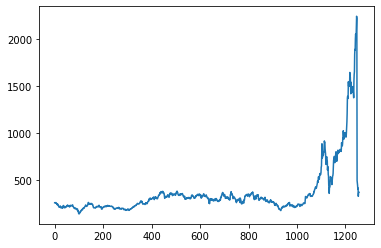

In [91]:
df1 = df.reset_index()['close']
plt.plot(df1)

In [92]:
df.tail()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
TSLA   2020-09-04 00:00:00+00:00  418.32  428.00  ...      0.0          1.0
       2020-09-08 00:00:00+00:00  330.21  368.74  ...      0.0          1.0
       2020-09-09 00:00:00+00:00  366.28  369.00  ...      0.0          1.0
       2020-09-10 00:00:00+00:00  371.34  398.99  ...      0.0          1.0
       2020-09-11 00:00:00+00:00  372.72  382.50  ...      0.0          1.0

[5 rows x 12 columns]

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [126]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [127]:
training_size,test_size

(817, 440)

In [128]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [129]:

# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [130]:

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [131]:
print(X_test.shape), print(ytest.shape)

(339, 100, 1)
(339,)


(None, None)

In [132]:

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow_addons.optimizers import AdamW
import tensorflow as tf

In [133]:
# optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [134]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_34 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_35 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [135]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=54,verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 86ms/step - loss: 0.0013 - val_loss: 0.0496
Epoch 2/100
14/14 [==============================] - 0s 19ms/step - loss: 4.8690e-04 - val_loss: 0.0336
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 2.0941e-04 - val_loss: 0.0131
Epoch 4/100
14/14 [==============================] - 0s 17ms/step - loss: 1.2781e-04 - val_loss: 0.0146
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 1.1597e-04 - val_loss: 0.0141
Epoch 6/100
14/14 [==============================] - 0s 17ms/step - loss: 1.1884e-04 - val_loss: 0.0133
Epoch 7/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0898e-04 - val_loss: 0.0132
Epoch 8/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0303e-04 - val_loss: 0.0132
Epoch 9/100
14/14 [==============================] - 0s 18ms/step - loss: 1.0598e-04 - val_loss: 0.0126
Epoch 10/100
14/14 [==============================] - 0s 18ms/step -

In [136]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [137]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [138]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

284.6839008328911

In [139]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

616.2440038402603

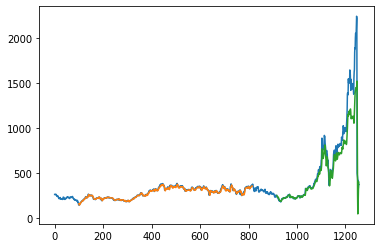

In [140]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [141]:
len(test_data)

440

In [142]:

x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [143]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [144]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.11602801]
101
1 day input [0.26822842 0.27754549 0.31267541 0.29853275 0.31351547 0.30462321
 0.26617122 0.29474769 0.2980984  0.30495733 0.30374496 0.32254138
 0.31866086 0.31776352 0.30895718 0.31486149 0.31287588 0.31977777
 0.31709529 0.32069897 0.32644577 0.32132902 0.32227886 0.322928
 0.31604521 0.32997785 0.36009603 0.35220135 0.35286958 0.34400118
 0.35415831 0.38483017 0.38041507 0.42069038 0.39577009 0.37784237
 0.40439029 0.40020429 0.40481509 0.41062394 0.40916337 0.40602268
 0.4095834  0.39004716 0.40204193 0.38951735 0.41319663 0.44682781
 0.46583424 0.50832904 0.58609218 0.59481738 0.58337152 0.59692709
 0.6687     0.64598488 0.65540695 0.66934914 0.64769364 0.64778911
 0.71564332 0.68001699 0.69145808 0.65362659 0.60777154 0.66628959
 0.63616664 0.64696336 0.64141703 0.61433931 0.64022854 0.64118315
 0.64023808 0.64241461 0.62481624 0.60852092 0.58743342 0.67352559
 0.70514252 0.71932337 0.80759207 0.83214961 0.82806384 0.88691601
 0.90989843 0.89282032 0.89718292 0

In [145]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
len(df1)

1257

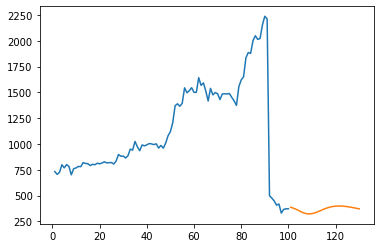

In [146]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

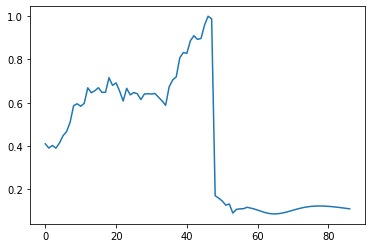

In [147]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

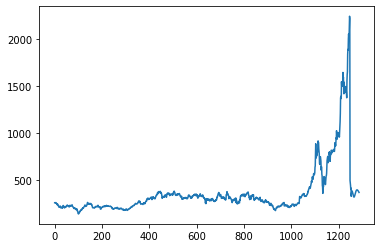

In [148]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)